# PLN Assignment 1

In the scope of the DARGMINTS project, an annotation project was carried out which consisted of annotating argumentation structures in opinion articles published in the Público newspaper. The annotation included several layers:

Selecting text spans that are taken to have an argumentative role (either as premises or conclusions of arguments) -- these are Argumentative Discourse Units (ADU).
Connecting such ADUs through support or attack relations.
Classifying the propositional content of ADUs as propositions of fact, propositions of value, or propositions of policy; within propositions of value, distinguish between those with a positive (+) or negative (-) connotation.
In a proposition of fact, the content corresponds to a piece of information that can be checked for truthness. This does not usually happen with propositions of value, which denote value judgments with a strong subjective nature; often, they also have a (positive or negative) polarity attached. A proposition of policy prescribes or suggests a certain line of action, often mentioning the agents or entities that are capable of carrying out such policies.

The aim of this assignment is to build a classifier of types of ADUs, thus focusing on the last annotation step described above. For that, you have access to two different files:

A file containing the content of each annotated ADU span and its 5-class classification: Value, Value(+), Value(-), Fact, or Policy. For each ADU, we also know the annotator and the document from which it has been taken.
A file containing details for each opinion article that has been annotated, including the full article content.
Besides ADU contents, you can make use of any contextual information provided in the corresponding opinion article.

Each opinion article has been annotated by 3 different annotators. For that reason, you will find in the ADU file an indication of which annotator has obtained the ADU. It may happen that the same ADU has been annotated by more than one annotator. When that is the case, they do not necessarily agree on the type of proposition.

How good a classifier (or set of classifiers) can you get? Don't forget to properly split the dataset in a sensible manner, so that you have a proper test set. Start by obtaining an arbitrary baseline, against which you can then compare your improvements.

## Importing the data

In order to fulfill this NLP task we will use `pandas`, `sklearn`, `nltk`, `numpy`, `matplotlib`, `seaborn` and other Python libraries


assignment1.ipynb  data/  exploratory_analysis.ipynb  README.md  statistics/


In [5]:
import pandas as pd
import numpy as np

ADUs = pd.read_excel("data/OpArticles_ADUs.xlsx")
articles = pd.read_excel("data/OpArticles.xlsx")

ADUs.isnull().values.any() #check NaNs


False

In [ ]:
ADUs["label"].value_counts()

Value       8102
Fact        3663
Value(-)    2900
Value(+)    1411
Policy       667
Name: label, dtype: int64

## Handling repeated text spans

Some text spans were annotated by more than one annotator. Therefore, it may be the case that some text spans have different labels, which may harm the training phase.

In [ ]:

unique_spans = np.unique(ADUs[['article_id', 'ranges']].values)
(unique_spans.shape, ADUs["tokens"].shape)

((12302,), (16743,))

As we can see, more than 4000 text spans were evaluated by more than one annotator. Now let's check how many of these text spans receive different labels

## Data preparation

The next step is to cleanup the dataset, applying text normalization techniques:
 - Removing non-alphabetic chars
 - Lowercasing
 - Removing stop words
 - Stemming/lemmatization
 
However, before applying these techniques, let's try to remove the repeated annotations that may confuse the classifiers on the future steps. In order to decide which is the correct label for each (article_id, range) pair, we compute the majority.

In [ ]:
grouped_df = ADUs.groupby(by=['article_id', 'ranges'])
dataset_dict = {"tokens": [], "label": []}

for i, group in grouped_df:
    dict_counts = {x: group["label"].value_counts()[x] for x in np.unique(group[['label']].values)}
    final_label = max(dict_counts.items(), key=lambda x: x[1])
    dataset_dict["tokens"].append(group["tokens"].values[0])
    dataset_dict["label"].append(final_label[0])
    
dataset = pd.DataFrame(dataset_dict, columns = ["tokens", "label"])



In [ ]:
print(ADUs["label"].value_counts())
dataset["label"].value_counts()

Value       8102
Fact        3663
Value(-)    2900
Value(+)    1411
Policy       667
Name: label, dtype: int64


Value       5748
Fact        3001
Value(-)    1872
Value(+)     889
Policy       511
Name: label, dtype: int64

We managed to reduce the amount of rows in the dataframe -> some of them had repeated/conflictuous labels. 

In [ ]:
!python -m spacy download pt_core_news_sm

In [ ]:
import spacy
from spacy.lang.pt.examples import sentences 
import pt_core_news_sm

nlp = pt_core_news_sm.load()
test_sentence = "Os combustíveis atingiram picos históricos na passada sexta-feira."
for token in nlp(test_sentence):
    print(token.text, token.pos_, token.dep_)

## POS-tagging

Apply POS-tagging (with a pre-trained model), to the full sentence of the corresponding text span.

In [ ]:
#Add a new column with POS-tags that will be gathered next
POS_list = []
#ADUs["POS"] = []

for row in ADUs.iterrows():
  POS_list.append((row[1]["article_id"] + row[1]["ranges"]))

ADUs["POS"] = POS_list

In [ ]:
import nltk


for i, group in grouped_df:
  article = articles.loc[articles["article_id"] == i[0]]
  
  range = group["ranges"].unique()[0]
  start = eval(range)[0][0]
  end = eval(range)[0][1] 
  body = article["body"].values[0]
  
  body_sentences = nltk.tokenize.sent_tokenize(body)
  current_pos, current_sent = 0,0
  while current_pos < start:
    if current_sent == len(body_sentences): break
    current_pos += len(body_sentences[current_sent])
    current_sent += 1
  #print(body_sentences[current_sent - 1])
  tags = [token.pos_ for token in nlp(body_sentences[current_sent - 1])]
  test = ADUs.loc[ADUs["POS"] == i[0] + i[1]]

  ADUs["POS"].replace(i[0] + i[1], " ".join(tags), inplace=True)

  

In [ ]:
ADUs["POS"].describe()

count                                    16743
unique                                    5836
top       DET NOUN VERB ADP DET ADJ NOUN PROPN
freq                                        57
Name: POS, dtype: object

## Extract features

Let's start by adding the count of each POS-tag for each document

In [ ]:
unique_tags_l = []

for tags in ADUs["POS"].values:
  tags_list = tags.split(" ")
  unique_tags_l += tags_list

unique_tags = set(unique_tags_l)
unique_tags


{'ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SPACE',
 'SYM',
 'VERB',
 'X'}

In [ ]:
tag_counts_dict = {}

for tag in list(unique_tags):
  name = tag + "_count"
  tag_counts_dict[name] = []
  for row in ADUs.iterrows():
    tags_list = row[1]["POS"].split(" ")
    tag_counts_dict[name].append(tags_list.count(tag))
    

for k in tag_counts_dict.keys():
  ADUs[k] = tag_counts_dict[k]


## Extract topics as features

In [ ]:
topics_l = []
for row in ADUs.iterrows():
  ID = row[1]["article_id"]
  article = articles.loc[articles["article_id"] == ID]
  topic = article["topics"].values[0]
  topics_l.append(topic)

ADUs["topics"] = topics_l

## Saving tagged data

In [ ]:
ADUs.to_excel("data/ADUs_pre-processed.xlsx")

## Reading the pre-processed dataset

In [ ]:
import pandas as pd
import numpy as np
import nltk

ADUs = pd.read_excel("data/ADUs_pre-processed.xlsx")

grouped_df = ADUs.groupby(by=['article_id', 'ranges'])
dataset_dict = {"tokens": [], "label": []}

for c in ADUs.columns[8:]:
    dataset_dict[c] = []

for i, group in grouped_df:
    dict_counts = {x: group["label"].value_counts()[x] for x in np.unique(group[['label']].values)}
    final_label = max(dict_counts.items(), key=lambda x: x[1])
    dataset_dict["tokens"].append(group["tokens"].values[0])
    dataset_dict["label"].append(final_label[0])

    for c in ADUs.columns[8:]:
        dataset_dict[c].append(group[c].values[0])
    
    
    
dataset = pd.DataFrame(dataset_dict, columns = dataset_dict.keys())

## Analyzing Stopwords
Some stopwords from `nltk` should not be ignored by the model, as they have correlation with the label.

In [ ]:
from nltk.corpus import stopwords
import nltk

stopwords_list = stopwords.words("portuguese")


stopwords_list.remove("não")
stopwords_list.remove("muito")
stopwords_list.remove("mais")

In [29]:

import re
#nltk.download('rslp')
from nltk.stem import RSLPStemmer # portuguese stemmer
corpus = []
stemmer = RSLPStemmer()
for i in range(0, dataset['tokens'].size):
    # get review and remove non alpha chars
    review = re.sub('[^a-zA-Z!?]', ' ', dataset['tokens'][i])
    # to lower-case
    review = review.lower()
    # split into tokens, apply stemming and remove stop words
    review = ' '.join([stemmer.stem(w) for w in review.split() if not w in stopwords_list])
    corpus.append(review)

#print(corpus)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
len(dataset["corpus"].values)

12021


## Generating a data set

We need to transform the corpus into a collection that can be handled by a machine learning model. We will be using `sklearn`'s TfidfVectorizer class

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


dataset["corpus"] = corpus
column_trans = ColumnTransformer([
    ("topics", OneHotEncoder(), ["topics"]),
    ("corpus", TfidfVectorizer(ngram_range=(1,2), min_df = 3), "corpus"),
    ("counts", "passthrough", ADUs.columns[8:-1])
], verbose_feature_names_out=False)

#vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df = 3)
X = column_trans.fit_transform(dataset).toarray()


In [86]:
y = dataset["label"]
print(y.shape)
print(y.head())

(12021,)
0    Value
1    Value
2    Value
3    Value
4    Value
Name: label, dtype: object


## Splitting the dataset into training and testing

The next step is to split the dataset into training and testing. We will be using a 80%-20% split. Since classes are unbalanced (*Value* examples are significantly more abundant than *Policy* examples), we need to stratify both sets -> try to get a similar class distribution for each set.

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

(9616, 8885) (9616,)
(2405, 8885) (2405,)

Label distribution in the training set:
Value       4623
Fact        2389
Value(-)    1496
Value(+)     699
Policy       409
Name: label, dtype: int64

Label distribution in the test set:
Value       1125
Fact         612
Value(-)     376
Value(+)     190
Policy       102
Name: label, dtype: int64


## Computing class weights

Since the dataset is unbalanced, we need to compute weights or apply oversampling/undersampling techniques. Otherwise predictions would be heavily biased towards the majority class.

In [88]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y.unique()),
                                        y = y                                                    
                                    )
class_weights = dict(zip(np.unique(y.unique()), class_weights))
class_weights

{'Fact': 0.8011329556814395,
 'Policy': 4.704892367906067,
 'Value': 0.4182672233820459,
 'Value(+)': 2.704386951631046,
 'Value(-)': 1.284294871794872}

## Training the models


In [50]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sb

cross_validation = StratifiedKFold(n_splits=5)

### Naive Bayes
To start off, we will train a single (`Naive Bayes`) classifier that evaluates the likelihood of a document being of one of the 5 classes. This will set the baseline for which the improvements will be measured.


In [90]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Accuracy score:  0.508939708939709


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


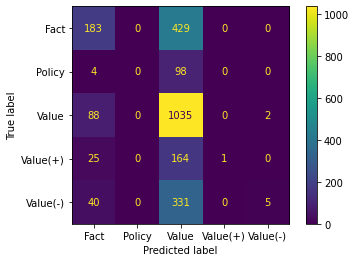

,Precision,Recall,F1
Fact,0.538235,0.299020,0.384454
Policy,0.000000,0.000000,0.000000
Value,0.503160,0.920000,0.650534
Value(+),1.000000,0.005263,0.010471
Value(-),0.714286,0.013298,0.026110


In [91]:

def print_metrics(y_test, y_pred, classes):
    cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    print("Accuracy score: ", accuracy_score(y_test, y_pred))
    metrics_df = pd.DataFrame({"Precision": precision_score(y_test, y_pred, labels = classes, average = None).tolist(),
                              "Recall": recall_score(y_test, y_pred, labels = classes, average = None).tolist(),
                              "F1": f1_score(y_test, y_pred, labels = classes, average = None).tolist()},
                             index = classes)
    
    plt.show()
    return metrics_df.head()
    
print_metrics(y_test, y_pred, clf.classes_)

Since some classifiers like SVM and Logistic Regression cannot handle multi-class classification, let's use the One vs Rest classifier. This way, we can transform this problem into a binary classification problem -> one classifier for each class.

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Accuracy score:  0.4856548856548857


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


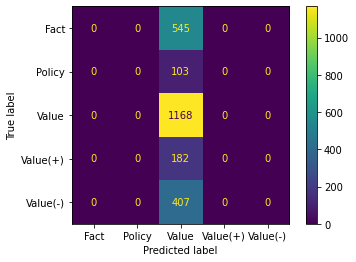

,Precision,Recall,F1
Fact,0.000000,0.0,0.000000
Policy,0.000000,0.0,0.000000
Value,0.485655,1.0,0.653792
Value(+),0.000000,0.0,0.000000
Value(-),0.000000,0.0,0.000000


In [ ]:
model_to_set = RandomForestClassifier(n_jobs=-1)

cross_validation = StratifiedKFold(n_splits=5)
parameters = {
    "max_depth": [int(x) for x in np.linspace(10, 110, num=5)],
    "min_samples_leaf": [int(x) for x in np.linspace(50, 2000, num=5)],
    "criterion": ["gini", "entropy"]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters,
                             scoring="accuracy", cv=cross_validation, n_jobs=-1, verbose=1)

model_tunning.fit(X_train, y_train)
model_tunning.best_score_
print_metrics(y_test, model_tunning.predict(X_test), clf.classes_)


## Scaling the data

Some linear models (like SVM or SGD classifiers) use euclidean distances and benefit from the normalization of the data.

In [77]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## SGD Classifier

Let's now apply the Stochastic Gradient Descent optimization with a linear SVM model (`loss='hinge'`) and a Logistic Regression model (`loss=log`). Moreover, we can tune some hyperparameters to get the best possible model.
SGD implementation from sklearn optimizes the loss function to converge faster, as they use stochastic gradient descent instead of gradient descent.

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'loss': 'log'}
Accuracy score:  0.4465696465696466


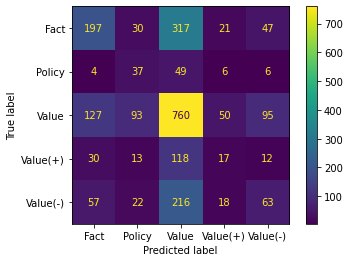

,Precision,Recall,F1
Fact,0.474699,0.321895,0.383642
Policy,0.189744,0.362745,0.249158
Value,0.520548,0.675556,0.588008
Value(+),0.151786,0.089474,0.112583
Value(-),0.282511,0.167553,0.210351


In [92]:
"""
l1-regularization -> 'built-in' feature selection (fewer features)
l2-regularization -> Prefers weight vectors with many small weights
"""

max_iterations = 10**6/np.ceil(X_train.shape[0] / 10) #Empirically,the model converges after 10^6/n where n 
                                        # the size of the test set

sgd_model = SGDClassifier(penalty="l2", 
                          max_iter=np.ceil(max_iterations/10), average=True, class_weight=class_weights)
sgd_gs = GridSearchCV(sgd_model, n_jobs=-1, param_grid={
    "alpha": 10.0**-np.arange(1,5),
    "loss": ['log', 'modified_huber']
}, cv=cross_validation, scoring="f1_weighted", verbose = 1)

sgd_gs.fit(X_train, y_train)
#sgd_gs.best_score_
print(sgd_gs.best_params_)
print_metrics(y_test, sgd_gs.predict(X_test), sgd_gs.classes_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 60.69, NNZs: 3167, Bias: -5.440951, T: 9616, Avg. loss: 25.651380
Total training time: 0.21 seconds.
-- Epoch 2
Norm: 91.15, NNZs: 6959, Bias: -8.246687, T: 9616, Avg. loss: 144.022222
Total training time: 0.29 seconds.
-- Epoch 2
Norm: 46.71, NNZs: 4024, Bias: -4.362401, T: 19232, Avg. loss: 6.025208
Total training time: 0.42 seconds.
-- Epoch 3
Norm: 66.04, NNZs: 7915, Bias: -9.123032, T: 19232, Avg. loss: 39.886255
Total training time: 0.58 seconds.
-- Epoch 3
Norm: 38.03, NNZs: 4617, Bias: -2.326471, T: 28848, Avg. loss: 4.071559
Total training time: 0.64 seconds.
-- Epoch 4
Norm: 36.40, NNZs: 5067, Bias: -2.979984, T: 38464, Avg. loss: 2.686858
Total training time: 0.86 seconds.
-- Epoch 5
Norm: 64.21, NNZs: 8304, Bias: -6.825809, T: 28848, Avg. loss: 23.455439
Total training time: 0.88 seconds.
-- Epoch 4
Norm: 33.87, NNZs: 5429, Bias: -2.373948, T: 48080, Avg. loss: 2.058557
Total training time: 1.07 seconds.
-- Epoch 6
Norm: 58.42, NNZs: 8501, Bias: 

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Accuracy score:  0.2993762993762994


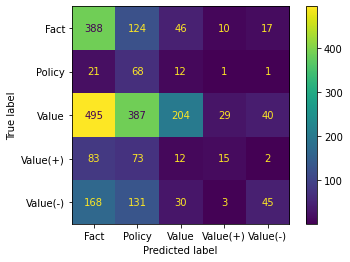

,Precision,Recall,F1
Fact,0.335931,0.663248,0.445977
Policy,0.086845,0.660194,0.153499
Value,0.671053,0.176623,0.279644
Value(+),0.258621,0.081081,0.123457
Value(-),0.428571,0.119363,0.186722


In [76]:
# Linear SVM model -> loss = 'hinge'

sgd_classifier = SGDClassifier(n_jobs=-1, penalty="l2", verbose = 1, shuffle=True, 
                               loss="hinge", max_iter=max_iterations)

sgd_classifier.fit(X_train, y_train)
print_metrics(y_test, sgd_classifier.predict(X_test), sgd_classifier.classes_)

## Linear SVM Classifier
To establish a comparison in terms of performance, we will use the Linear SVM classifier.


In [78]:

svm_model = LinearSVC(class_weight="balanced", verbose=1)

svm_gs = HalvingGridSearchCV(svm_model, n_jobs=-1, param_grid = {
    "C": np.logspace(-4,4,5),
    "loss": ["hinge", "squared_hinge"]
}, cv=5, scoring="f1_weighted", verbose=3)

svm_gs.fit(X_train, y_train)
print_metrics(y_test, svm_gs.predict(X_test), svm_gs.classes_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1068
max_resources_: 9616
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 1068
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 1
n_candidates: 4
n_resources: 3204
Fitting 5 folds for each of 4 candidates, totalling 20 fits


KeyboardInterrupt: ignored

## Logistic Regression Classifier
We can now do the same apply the Logistic Regression classifier and compare it with the previously obtained models with SGD optimization.


In [ ]:

# Logistic Regression model
lr_model = LogisticRegression(n_jobs=-1, verbose=1)

lr_gs = GridSearchCV(lr_model, n_jobs=-1, param_grid={
    "max_iter": [100, 200, 500, 1000],
    "solver": ["sag", 'saga', 'lbfgs', "newton-cg"],
    "C": np.logspace(-4, 4, 20)
}, cv=cross_validation, scoring="accuracy", verbose = True)

lr_gs.fit(X_train, y_train)
print_metrics(y_test, lr_gs.predict(X_test), lr_gs.classes_)